# Ignite 2024 Demo: Advanced Multimmodal RAG with Azure AI Search and LlamaIndex
This notebook demonstrates the implementation of a sophisticated Multi-Modal Retrieval-Augmented Generation (RAG) system using Azure AI Search, Azure OpenAI services and LlamaIndex. The system processes both text and images from PDF documents, storing them in Azure Blob Storage and Azure AI Search for efficient retrieval.

## Prerequisites
- 🐍 Python 3.9+
- 🔑 Azure OpenAI Service 
- 🔍 Azure AI Search
- 📦 Azure Blob Storage

## Key Features
- 🎯 Multi-Modal RAG
  - ✅ PDF Processing (Text + Images) via LlamaParse Premium
  - ✅ Vector/Hybrid Search with Azure AI Search
  - ✅ GPT-4o for multimodal generative exerpeince!

## Setup and Dependencies
First, let's install the required packages:

In [ ]:
! pip install chainlit
! pip install llama-index-vector-stores-azureaisearch==0.2.8
! pip install azure-storage-blob
! pip install python-dotenv

## Environment Configuration and Imports

In [101]:
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from llama_parse import LlamaParse
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode
import nest_asyncio
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

## (Optional) Initialize Monitoring with Arize Phoenix
Arize Phoenix provides real-time tracing capabilities for LlamaIndex applications.

In [ ]:
# import phoenix as px
# import llama_index.core

# px.launch_app()
# llama_index.core.set_global_handler("arize_phoenix")

## Azure OpenAI Configuration
Initialize Azure OpenAI models for embeddings and completion:

In [ ]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-azure-aisearch-rag"

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

## Document Processing and Image Extraction
We use LlamaParse with our custom Azure OpenAI chat completion model to extract text and images from PDF documents. We'll use GPT-4o here.

In [ ]:
# Azure Blob Configuration
BLOB_CONNECTION_STRING = os.getenv("BLOB_CONNECTION_STRING")
BLOB_STORAGE_ACCOUNT_KEY = os.getenv("BLOB_STORAGE_ACCOUNT_KEY")
BLOB_CONTAINER_NAME = "ignite-demo-images"

# Set up download path and parser
DOWNLOAD_PATH = "data_images_state_of_ai_report_2024"
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    azure_openai_endpoint=f"{AZURE_OPENAI_ENDPOINT}openai/deployments/{AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME}chat/completions?api-version=2024-08-01-preview",
    azure_openai_api_version="2024-08-01-preview",
    azure_openai_key=AZURE_OPENAI_API_KEY,
)

# Parse document and extract images
md_json_objs = parser.get_json_result("data/llamaparse/State of AI Report 2024.pdf")
md_json_list = md_json_objs[0]["pages"]
image_dicts = parser.get_images(md_json_objs, download_path=DOWNLOAD_PATH)

Started parsing the file under job_id 13adf850-f8c5-4ad6-bd0c-a65a8c129dce
> Image for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 8: [{'name': 'page_8.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_

## Asynchronous Image Upload to Azure Blob Storage
Implement efficient concurrent image uploads with rate limiting:

(For demo purposes, I've made the blob storage public - be extra secure and use SAS tokens with private data!)

In [98]:
# Limit the number of concurrent uploads
CONCURRENT_UPLOADS = 5

async def create_container_if_not_exists(connection_string: str, container_name: str):
    """Create container if it doesn't exist, handling the operation once."""
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    async with blob_service_client:
        container_client = blob_service_client.get_container_client(container_name)
        if not await container_client.exists():
            try:
                await container_client.create_container()
                print(f"Container {container_name} created successfully")
            except Exception as e:
                print(f"Error creating container: {e}")

async def upload_image_to_blob_storage(image, blob_name, semaphore):
    """Upload a single image to blob storage."""
    async with semaphore:
        try:
            image_path = image.get('path') or image.get('original_file_path')
            if not image_path or not os.path.exists(image_path):
                print(f"Image path not found or invalid: {image_path}")
                return None

            blob_service_client = BlobServiceClient.from_connection_string(BLOB_CONNECTION_STRING)
            async with blob_service_client:
                container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
                blob_client = container_client.get_blob_client(blob_name)

                with open(image_path, "rb") as f:
                    await blob_client.upload_blob(f, overwrite=True)
                    print(f"Successfully uploaded {blob_name}")
                return blob_client.url

        except Exception as e:
            print(f"Failed to upload {blob_name}: {str(e)}")
            return None

async def main():
    """Main function to handle container creation and image uploads."""
    # First, ensure the container exists
    await create_container_if_not_exists(BLOB_CONNECTION_STRING, BLOB_CONTAINER_NAME)
    
    # Then proceed with uploads
    semaphore = asyncio.Semaphore(CONCURRENT_UPLOADS)
    upload_tasks = [upload_image_to_blob_storage(image, image["name"], semaphore) 
                   for image in image_dicts]
    
    results = await asyncio.gather(*upload_tasks)
    
    # Create dictionary of successful uploads
    successful_uploads = {
        image["name"]: url
        for image, url in zip(image_dicts, results)
        if url is not None
    }
    
    # Print summary
    print(f"\nUpload Summary:")
    print(f"Total images: {len(image_dicts)}")
    print(f"Successfully uploaded: {len(successful_uploads)}")
    print(f"Failed uploads: {len(image_dicts) - len(successful_uploads)}")
    
    return successful_uploads

# Run the main function
image_urls = asyncio.run(main())

Container ignite-demo-images created successfully
Successfully uploaded page_1.jpg
Successfully uploaded page_2.jpg
Successfully uploaded page_3.jpg
Successfully uploaded page_4.jpg
Successfully uploaded page_5.jpg
Successfully uploaded page_9.jpg
Successfully uploaded page_7.jpg
Successfully uploaded page_6.jpg
Successfully uploaded page_8.jpg
Successfully uploaded page_10.jpg
Successfully uploaded page_11.jpg
Successfully uploaded page_12.jpg
Successfully uploaded page_13.jpg
Successfully uploaded page_14.jpg
Successfully uploaded page_15.jpg
Successfully uploaded page_16.jpg
Successfully uploaded page_17.jpg
Successfully uploaded page_18.jpg
Successfully uploaded page_19.jpg
Successfully uploaded page_20.jpg
Successfully uploaded page_21.jpg
Successfully uploaded page_22.jpg
Successfully uploaded page_23.jpg
Successfully uploaded page_24.jpg
Successfully uploaded page_25.jpg
Successfully uploaded page_26.jpg
Successfully uploaded page_27.jpg
Successfully uploaded page_28.jpg
Success

## Text Node Creation
Create text nodes with associated metadata:

In [108]:
def get_page_number(file_name: str) -> int:
    """Extract page number from blob name."""
    match = re.search(r"page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_blob_urls(image_urls: Dict[str, str]) -> List[str]:
    """Get blob URLs sorted by page number."""
    sorted_items = sorted(image_urls.items(), key=lambda x: get_page_number(x[0]))
    return [url for _, url in sorted_items]

def get_text_nodes(image_urls: Dict[str, str], json_dicts: List[dict]) -> List[TextNode]:
    """Create TextNodes with metadata including blob URLs as image_path."""
    nodes = []
    
    sorted_urls = _get_sorted_blob_urls(image_urls)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        if idx >= len(sorted_urls):
            continue
            
        node = TextNode(
            text=md_text,
            metadata={
                "page_num": idx + 1,
                "image_path": sorted_urls[idx],
                "parsed_text_markdown": md_texts[idx],
            }
        )
        nodes.append(node)

    return nodes

# Create text nodes
text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# Print an example node to verify
print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

page_num: 1
image_path: https://ignite2024demo.blob.core.windows.net/ignite-demo-images/page_1.jpg
parsed_text_markdown: # STATE OF AI REPORT

October 10, 2024

Nathan Benaich

**AIR STREET CAPITAL**

[stateof.ai](http://stateof.ai) | [airstreet.com](http://airstreet.com)

# STATE OF AI REPORT

October 10, 2024

Nathan Benaich

**AIR STREET CAPITAL**

[stateof.ai](http://stateof.ai) | [airstreet.com](http://airstreet.com)


## Vector Store Integration
Initialize and configure the Azure AI Search vector store:

In [100]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

def create_vector_store(
    index_client,
    index_name: str,
    use_existing_index: bool = False
) -> AzureAISearchVectorStore:
    """Create or get existing Azure AI Search vector store."""
    return AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name=index_name,
        index_management=IndexManagement.VALIDATE_INDEX if use_existing_index 
                        else IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

def create_or_load_index(
    text_nodes,
    index_client,
    index_name: str,
    embed_model,
    llm,
    use_existing_index: bool = False
) -> VectorStoreIndex:
    """Create new index or load existing one."""
    vector_store = create_vector_store(index_client, index_name, use_existing_index)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    if use_existing_index:
        return VectorStoreIndex.from_documents(
            [],
            storage_context=storage_context,
        )
    else:
        return VectorStoreIndex(
            nodes=text_nodes,
            storage_context=storage_context,
            embed_model=embed_model,
            llm=llm,
            show_progress=True,
        )

# Initialize vector store index
index = create_or_load_index(
    text_nodes=text_nodes,
    index_client=index_client,
    index_name=INDEX_NAME,
    embed_model=embed_model,
    llm=llm,
    use_existing_index=False
)

Generating embeddings:   0%|          | 0/212 [00:00<?, ?it/s]

## Custom Multmodal Query Engine
Implement the specialized query engine for handling both text and image queries:

In [106]:


# Define QA prompt template
QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine for public blob storage."""

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str) -> Response:
        # Retrieve relevant nodes
        nodes = self.retriever.retrieve(query_str)

        # Create ImageNode items directly using the blob URLs
        image_nodes = []
        for n in nodes:
            if "image_path" in n.metadata:
                try:
                    image_nodes.append(
                        NodeWithScore(
                            node=ImageNode(image_url=n.metadata["image_path"])
                        )
                    )
                except Exception as e:
                    print(
                        f"Warning: Failed to create ImageNode for {n.metadata['image_path']}: {str(e)}"
                    )
                    continue

        # Create context string from text nodes
        context_str = "\n\n".join(
            [node.get_content(metadata_mode=MetadataMode.LLM) for node in nodes]
        )

        # Format the prompt
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)
        # Get response from multimodal LLM
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )

        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )


# Initialize GPT-4o multimodal model
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-08-01-preview",
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

# Create and initialize the query engine
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3 # default is pure vector search, try HYBRID or SEMANTIC_HYBRID
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

## Testing the System
Let's test our multi-modal RAG system with some example queries:

Query: What impact does ColPali's use of visual structure have on improving retrieval performance in vision-language models, compared to traditional text-based embeddings?
Retrieved Images:



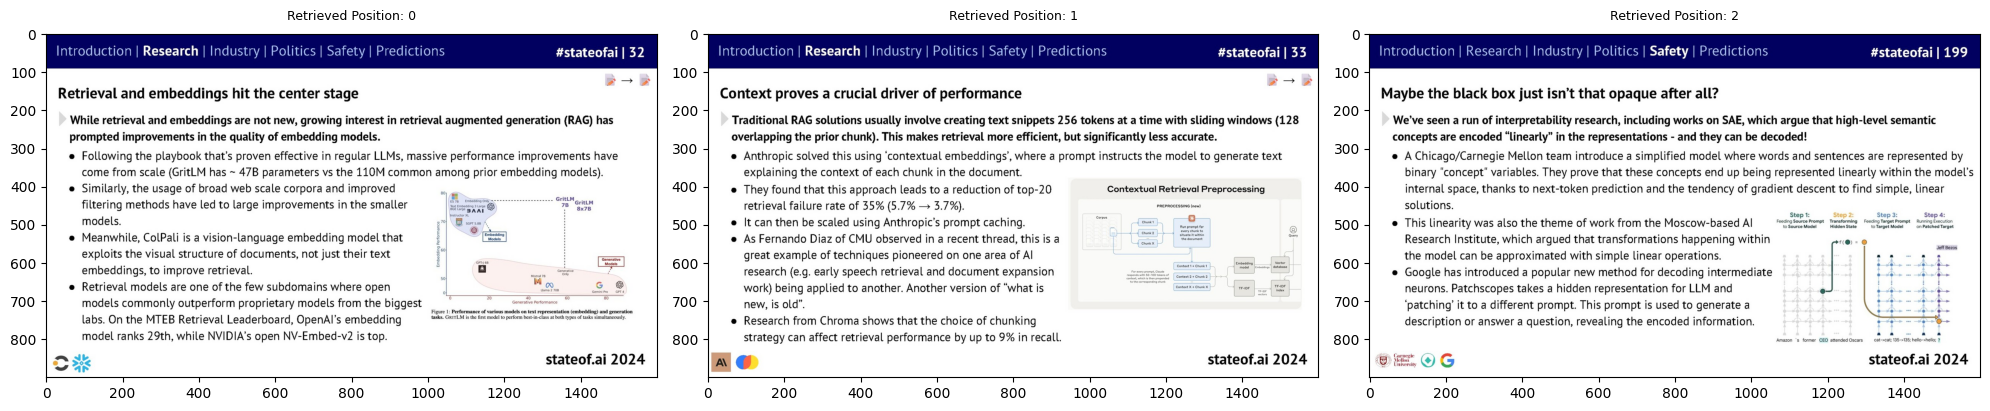

Response: The answer to the query about the impact of ColPali's use of visual structure on improving retrieval performance in vision-language models, compared to traditional text-based embeddings, is found in the parsed markdown from page 32.

### Answer:
ColPali is a vision-language embedding model that exploits the visual structure of documents, not just their text embeddings, to improve retrieval performance. This approach contrasts with traditional text-based embeddings, which primarily rely on textual information. By incorporating visual elements, ColPali enhances the retrieval process, potentially leading to better performance in tasks that require understanding both text and images.

### Source of Information:
This information was derived from the parsed markdown text on page 32, which discusses ColPali's capabilities and its role in improving retrieval performance. There are no discrepancies between the parsed markdown and the raw text or images, as the markdown provides a clea

In [123]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node

# Example query focused on visual and textual content
query = "What impact does ColPali's use of visual structure have on improving retrieval performance in vision-language models, compared to traditional text-based embeddings?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))

Query: How did the CIFAR-10 and CIFAR-100 datasets perform using adversarial accuracy in different models, and how does this relate to the training improvements for MobileCLIP in terms of image-text pairing on smartphones?
Retrieved Images:



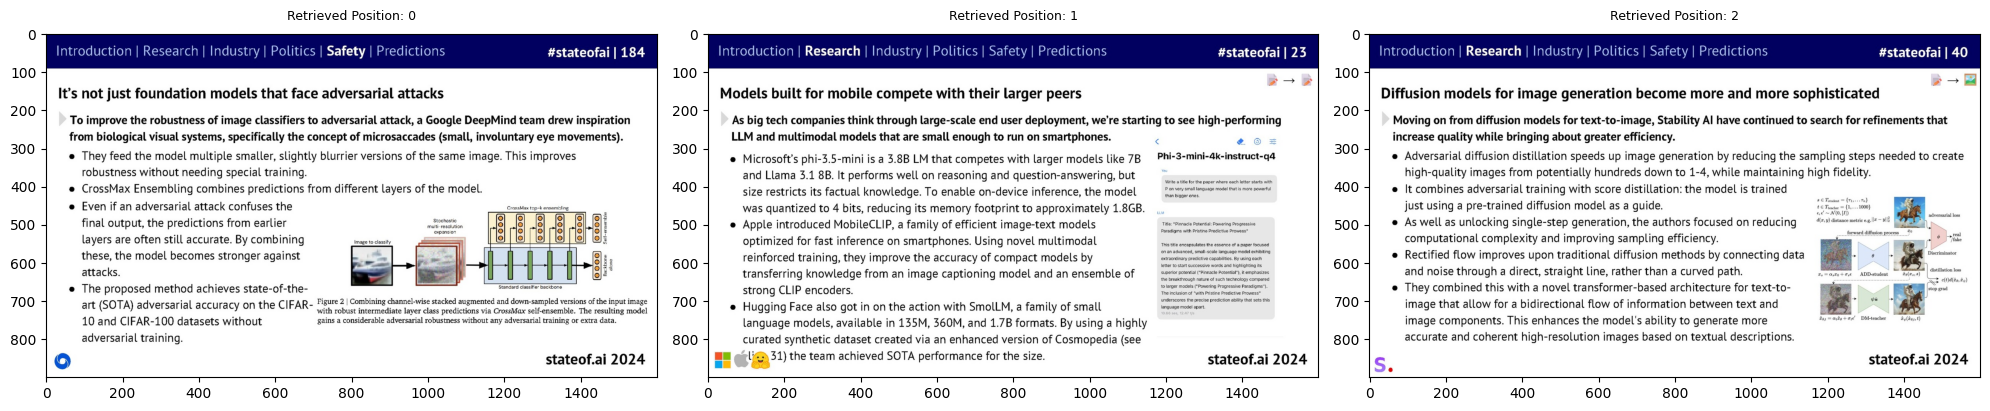

Response: The answer to the query is derived from the parsed markdown text, specifically from the sections discussing the adversarial accuracy of models on the CIFAR-10 and CIFAR-100 datasets and the training improvements for MobileCLIP.

1. **CIFAR-10 and CIFAR-100 Performance**: The parsed text mentions that the proposed method achieves state-of-the-art (SOTA) adversarial accuracy on the CIFAR-10 and CIFAR-100 datasets without adversarial training. This indicates that the model's performance on these datasets is significantly improved through the methods described, such as CrossMax Ensembling.

2. **MobileCLIP Training Improvements**: The section on MobileCLIP explains that it uses novel multimodal reinforced training to improve the accuracy of compact models by transferring knowledge from an image captioning model and an ensemble of strong CLIP encoders. This relates to the training improvements for image-text pairing on smartphones, emphasizing the efficiency and effectiveness of t

In [124]:
# Example query focused on visual and textual content
query = "How did the CIFAR-10 and CIFAR-100 datasets perform using adversarial accuracy in different models, and how does this relate to the training improvements for MobileCLIP in terms of image-text pairing on smartphones?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))

Query: What are the comparative benefits of using Sora's spacetime patches for video generation versus Veo's compressed video inputs in the diffusion process?
Retrieved Images:



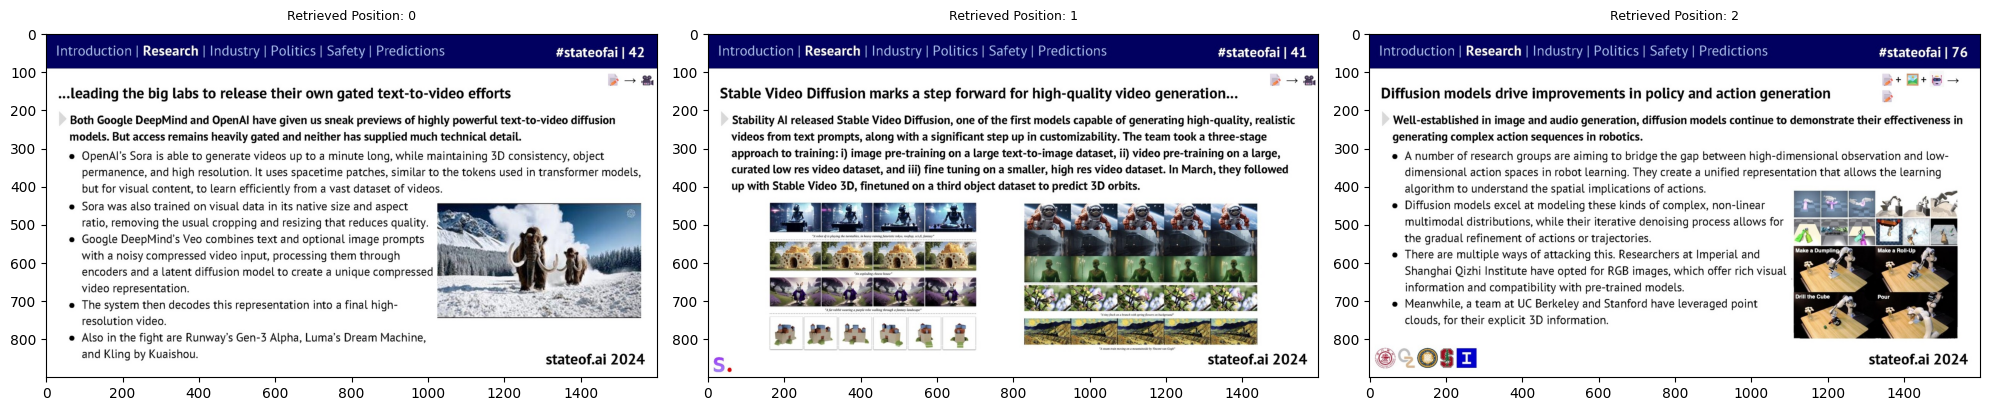

Response: The answer regarding the comparative benefits of using Sora's spacetime patches versus Veo's compressed video inputs in the diffusion process is derived from the parsed markdown text.

From the parsed text for Sora, it states that:

- **Sora** uses spacetime patches, which are similar to tokens in transformer models, allowing it to learn efficiently from a vast dataset of videos while maintaining 3D consistency, object permanence, and high resolution.

For **Veo**, the text mentions:

- **Veo** combines text and optional image prompts with a noisy compressed video input, processing them through encoders and a latent diffusion model to create a unique compressed video representation.

### Comparative Benefits:
- **Sora's spacetime patches** allow for efficient learning from a large dataset while maintaining high quality and 3D consistency.
- **Veo's approach** focuses on integrating text and image prompts with compressed video inputs, which may enhance flexibility but relies o

In [122]:
# Example query focused on visual and textual content
query = "What are the comparative benefits of using Sora's spacetime patches for video generation versus Veo's compressed video inputs in the diffusion process?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))

## Running the Chainlit Interface

To interact with this RAG system through a user-friendly chat interface, you can use Chainlit. The interface provides a conversational way to query your documents and see responses with both text and images.

### Steps to Run the Chainlit App:

1. Ensure all your code is saved in `ignite-chainlit.py`
2. Open your terminal in the project directory
3. Run the following command:
   ```bash
   chainlit run ignite-chainlit.py -w

The -w flag enables hot-reloading for development.

The Chainlit interface will be available at http://localhost:8000 by default. You can interact with your RAG system through a modern, responsive web interface that makes it easy to visualize both text and image responses.
Note: Make sure your environment variables and Azure services are properly configured before running the Chainlit app.